<a href="https://colab.research.google.com/github/catastropiyush/TransformerAsOn/blob/master/Phase_transitions_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile requirements.txt
scipy
matplotlib
datasets
vllm
accelerate>=0.26.0

Writing requirements.txt


In [2]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 

In [3]:
!pip install huggingface_hub

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import os
import json
import numpy as np
from huggingface_hub import snapshot_download
os.environ["VLLM_LOGGING_LEVEL"] = "ERROR"

import torch
import torch.distributed as dist
from datasets import load_dataset
from vllm import LLM, SamplingParams

!mkdir -p "/content/models"
!mkdir -p "/content/outputs"

def download_model(model_name):
    print(f"Downloading {model_name}...")
    local_path = f"/content/models/{model_name.split('/')[-1]}"

    if not os.path.exists(local_path):
        snapshot_download(
            repo_id=model_name,
            local_dir=local_path,
            ignore_patterns=["*.md", "*.pt", "*.bin", "*.txt"],
        )
    return local_path

# Set and download model
model_name = "Qwen/Qwen2.5-0.5B"
#model_name = "meta-llama/Llama-3.2-1B"
local_model_path = download_model(model_name)
print(f"Model downloaded to {local_model_path}")

# Load the dataset
ds = load_dataset("sentence-transformers/simple-wiki")

# Initialize LLM
llm = LLM(
    model=local_model_path,
    trust_remote_code=True,
    max_model_len=2048,
    tensor_parallel_size=1,
    dtype="float16"
)

def gen_with_T(T, max_tokens=1024):
    T = float("%.4f"%(T))
    params = SamplingParams(
        n=1,
        temperature=T,
        max_tokens=max_tokens,
        min_tokens=max_tokens-1,
        seed=42,
        skip_special_tokens=True
    )

    model_family = model_name.split("/")[-2]
    file_perfix = model_name.split("/")[-1]

    # Store outputs locally in Colab
    output_dir = f"/content/outputs/{model_family}"
    os.makedirs(output_dir, exist_ok=True)
    fname = f"{output_dir}/{file_perfix}-T{T}.json"

    if os.path.exists(fname):
        print(f"{fname} already exists, skipping")
        return

    try:
        # Take a smaller subset for Colab
        sample_texts = [i for i in ds['train']['text']][::2000]
        outputs = llm.generate(sample_texts, params)

        data = []
        for output in outputs:
            prompt = output.prompt
            generated = output.outputs[0]
            data.append({
                "prompt": prompt,
                "generated": generated.text
            })

        with open(fname, "w") as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        print(f"saved to {fname}")

    finally:
        if dist.is_initialized():
            dist.destroy_process_group()

if __name__=="__main__":
    for T in np.linspace(0, 10, 6):
        gen_with_T(T)

    for T in np.linspace(0, 2, 11):
        gen_with_T(T)

print("\nGenerated files:")
!ls -R /content/outputs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Model downloaded to /content/models/Qwen2.5-0.5B


README.md: 0.00B [00:00, ?B/s]

pair/train-00000-of-00001.parquet:   0%|          | 0.00/18.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/102225 [00:00<?, ? examples/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]

Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T0.0.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T2.0.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T4.0.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T6.0.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T8.0.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T10.0.json
/content/outputs/Qwen/Qwen2.5-0.5B-T0.0.json already exists, skipping


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T0.2.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T0.4.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T0.6.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T0.8.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T1.0.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T1.2.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T1.4.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T1.6.json


Adding requests:   0%|          | 0/52 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/52 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T1.8.json
/content/outputs/Qwen/Qwen2.5-0.5B-T2.0.json already exists, skipping

Generated files:
/content/outputs:
Qwen

/content/outputs/Qwen:
Qwen2.5-0.5B-T0.0.json	Qwen2.5-0.5B-T10.0.json  Qwen2.5-0.5B-T1.8.json
Qwen2.5-0.5B-T0.2.json	Qwen2.5-0.5B-T1.0.json	 Qwen2.5-0.5B-T2.0.json
Qwen2.5-0.5B-T0.4.json	Qwen2.5-0.5B-T1.2.json	 Qwen2.5-0.5B-T4.0.json
Qwen2.5-0.5B-T0.6.json	Qwen2.5-0.5B-T1.4.json	 Qwen2.5-0.5B-T6.0.json
Qwen2.5-0.5B-T0.8.json	Qwen2.5-0.5B-T1.6.json	 Qwen2.5-0.5B-T8.0.json


In [6]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils tex-common
  tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-framework-java l

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [8]:
!pip install transformers
!pip install tqdm

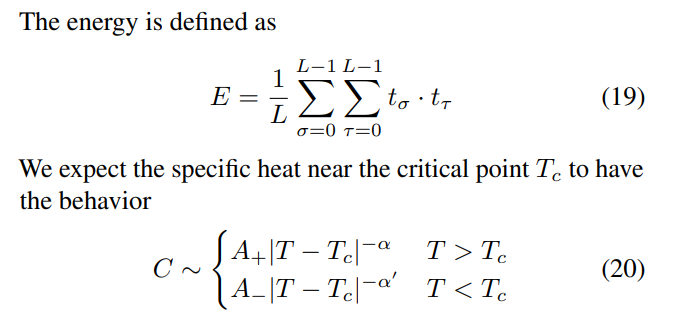

using Qwen/Qwen2.5-0.5B


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T0.0.json: 1023.92
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T0.2.json: 1023.90
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T0.4.json: 1023.79
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T0.6.json: 1023.27
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T0.8.json: 1023.50
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T1.0.json: 1022.37
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T1.2.json: 1027.69
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T1.4.json: 1031.65
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T1.6.json: 1035.88
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T1.8.json: 1040.33
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T2.0.json: 1043.12
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T4.0.json: 1057.23
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T6.0.json: 1060.25
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T8.0.json: 1063.52
avg length for /content/outputs/Qw

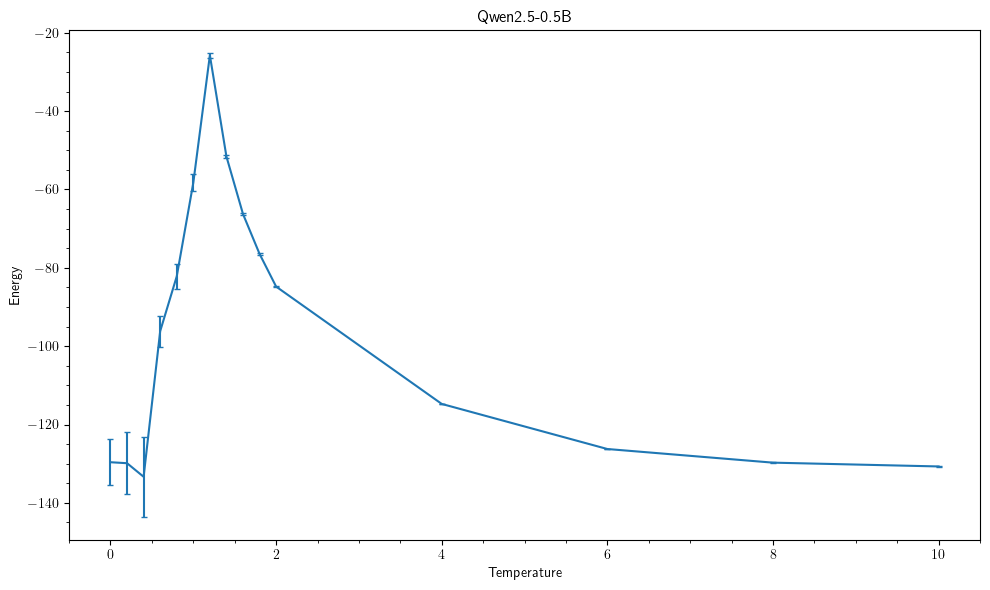


Generated files:
/content/data:
Qwen-energy.json
/content/plots:
energy_Qwen2.5-0.5B-0-10.pdf


In [9]:
import os
import re
import math
import json
import numpy as np
from matplotlib import pyplot as plt

import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# Create output directories
!mkdir -p "/content/data"
!mkdir -p "/content/plots"

model_name = os.getenv("model_name", "Qwen/Qwen2.5-0.5B")  # Default model if not set
#model_name = os.getenv("model_name", "meta-llama/Llama-3.2-1B")  # Default model if not set
print("using %s"%(model_name))

if not model_name[0].isalpha():
    model_name = os.path.expanduser(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto"
)
embed_tokens = model.get_input_embeddings()

def get_files(dir, file_perfix):
    text_files = []
    for i in os.listdir("/content/outputs/%s"%(dir)):  # Changed path to Colab directory
        r = re.search("%s-T([0-9\.]+?)\.json"%(file_perfix), i)
        if not r:
            continue
        T = float(r.group(1))
        text_files.append({
            "T": T,
            "path": "/content/outputs/%s/%s"%(dir,i)  # Changed path to Colab directory
        })
    text_files.sort(key=lambda x: x["T"])
    return text_files

def load_json(filename):
    if os.path.exists(filename):
        with open(filename, "r") as f:
            data = json.load(f)
    else:
        data = {}
    return data

def add_log(filename, entry, data):
    json_data = load_json(filename)
    if entry not in json_data:
        json_data[entry] = data
    else:
        json_data[entry] = {**json_data[entry], **data}

    lines = []
    for k, v in json_data.items():
        lines.append("\"%s\": %s"%(k, json.dumps(v)))
    with open(filename, "w") as f:
        f.write("{\n")
        f.write(",\n".join(lines))
        f.write("\n}")

def energy(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    with torch.no_grad():
        energies = []
        lengths  = []
        for d in data:
            model_inputs  = tokenizer(d["generated"], return_tensors="pt").to(model.device)
            inputs_embeds = embed_tokens(model_inputs["input_ids"]) # 1, len, 1536
            inputs_embeds = inputs_embeds.squeeze(0)
            inputs_embeds/= torch.linalg.vector_norm(inputs_embeds, dim = -1, keepdim = True)
            attn = -inputs_embeds@inputs_embeds.T # attn[i,j] = ei cdot ej
            attn.fill_diagonal_(0.0)
            e = (attn.sum()/attn.shape[0]).item()
            energies.append(e)
            lengths.append(attn.shape[0])
    print("avg length for %s: %.2f"%(filename, np.mean(lengths)))
    return np.mean(energies), np.std(energies)/math.sqrt(len(data))

def susceptibility(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    N = 512
    with torch.no_grad():
        spins = []
        for d in data:
            model_inputs  = tokenizer(d["generated"], return_tensors="pt").to(model.device)
            inputs_embeds = embed_tokens(model_inputs["input_ids"]) # 1, len, 1536
            inputs_embeds = inputs_embeds.squeeze(0)
            inputs_embeds/= torch.linalg.vector_norm(inputs_embeds, dim = -1, keepdim = True)
            spins.append(inputs_embeds[-N:,:]) # N x 896

    spins = torch.stack(spins)
    spinsbar = spins.mean(dim=0)
    deltaspins = spins - spinsbar # 103 x 1000 x 896
    sisj = []
    for i in range(N):
        for j in range(i+1,N):
            sisj.append((deltaspins[:,i,:]*deltaspins[:,j,:]).sum(dim=-1).mean().item())
    return np.mean(sisj)

def plot_energy(plot_flag=True):
    dir, file_perfix = model_name.split("/")[-2:] # Qwen, Qwen2.5-32B
    text_files = get_files(dir, file_perfix)

    betas, energies, sigmas = [], [], []
    for i in text_files:
        T, path = i["T"], i["path"]
        e, s = energy(path)
        betas.append(T)
        energies.append(e)
        sigmas.append(s)

    print(list(zip(betas, [float("%2.f"%(e)) for e in energies])))

    # Save energy data to local Colab directory
    energy_file = "/content/data/%s-energy.json"%(dir)
    add_log(energy_file, file_perfix, {
        "model_size": model.num_parameters(exclude_embeddings=True),
        "betas": betas,
        "energies": energies,
        "sigmas": sigmas
    })

    if not plot_flag:
        return

    Tmin = round(min(betas))
    Tmax = round(max(betas))

    plt.figure(figsize=(10, 6))
    plt.errorbar(betas, energies, yerr=sigmas, capsize=2)
    plt.minorticks_on()
    #plt.grid(True, which="both")
    plt.xlabel("Temperature")
    plt.ylabel("Energy")
    plt.title(file_perfix)
    plt.tight_layout()

    plot_path = f"/content/plots/energy_{file_perfix}-{Tmin}-{Tmax}.pdf"
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")

    plt.show()

if __name__=="__main__":
    plot_energy()

print("\nGenerated files:")
!ls -R /content/data
!ls -R /content/plots

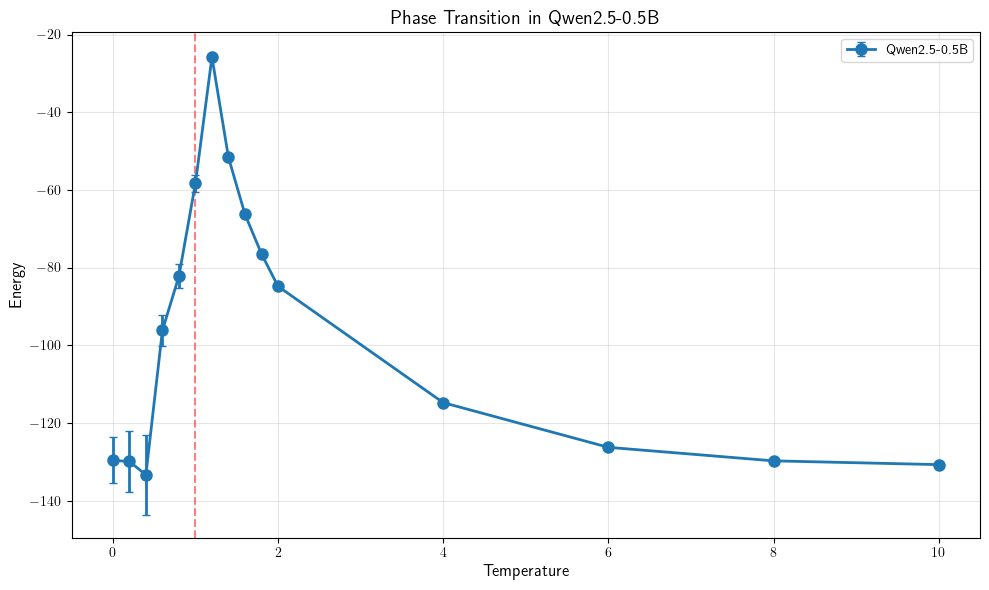

Estimated critical temperature: 1.00


In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the energy data
def load_energy_data(model_family="Qwen"):
    with open(f"/content/data/{model_family}-energy.json", "r") as f:
        data = json.load(f)
    return data

def plot_phase_transition(model_family="Qwen", model_size="Qwen2.5-0.5B"):
    data = load_energy_data(model_family)
    model_data = data[model_size]

    # Extract data
    temperatures = np.array(model_data['betas'])
    energies = np.array(model_data['energies'])
    errors = np.array(model_data['sigmas'])

    plt.figure(figsize=(10, 6))
    plt.errorbar(temperatures, energies, yerr=errors,
                fmt='o-', capsize=3, markersize=8,
                linewidth=2, label=model_size)

    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Energy', fontsize=12)
    plt.title(f'Phase Transition in {model_size}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add vertical line at potential critical temperature
    critical_temp = temperatures[np.argmax(np.gradient(energies))]
    plt.axvline(x=critical_temp, color='r', linestyle='--',
                alpha=0.5, label=f'Tc ≈ {critical_temp:.2f}')

    plt.tight_layout()
    plt.show()

    print(f"Estimated critical temperature: {critical_temp:.2f}")


plot_phase_transition()

# models = ["Qwen2.5-0.5B", "Qwen2.5-1.5B", "Qwen2.5-7B"]
# for model in models:
#     plot_phase_transition(model_size=model)

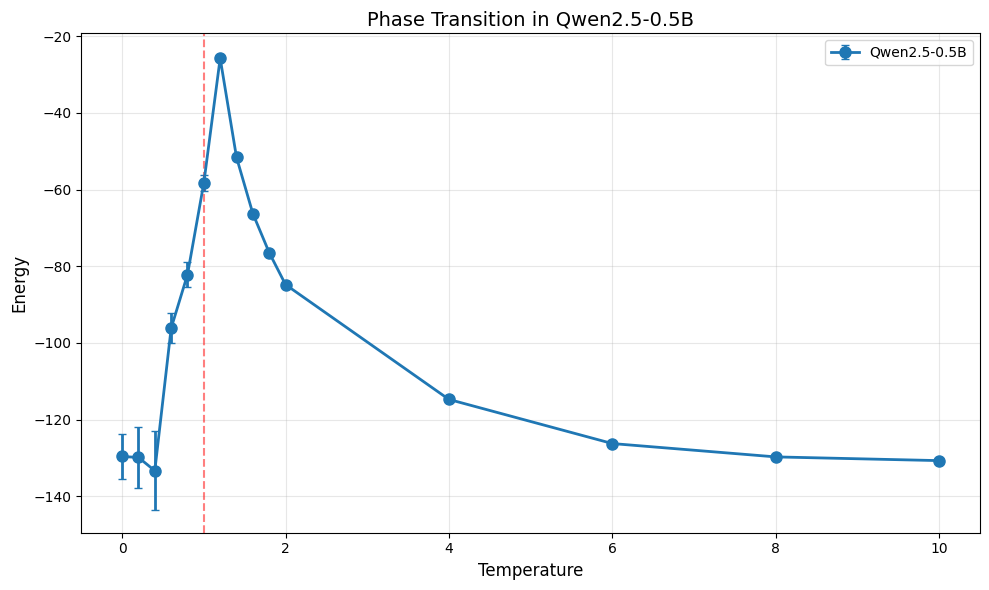

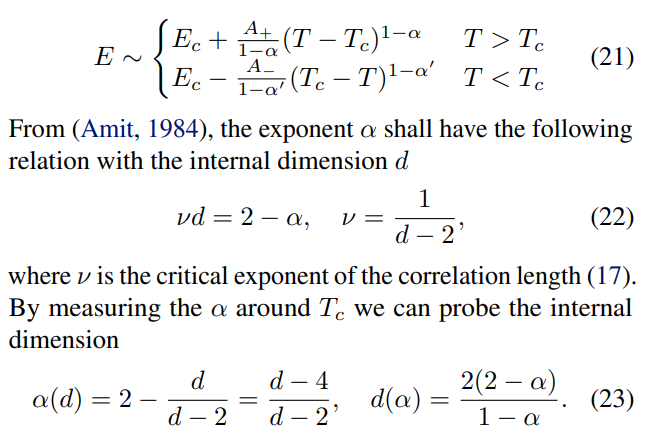

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_susceptibility(model_name="Qwen/Qwen2.5-0.5B"):
    dir, file_perfix = model_name.split("/")[-2:]
    text_files = []

    # Get files
    for i in os.listdir(f"/content/outputs/{dir}"):
        r = re.search(f"{file_perfix}-T([0-9\.]+?)\.json", i)
        if not r:
            continue
        T = float(r.group(1))
        text_files.append({
            "T": T,
            "path": f"/content/outputs/{dir}/{i}"
        })
    text_files.sort(key=lambda x: x["T"])

    # Calculate susceptibility for each temperature
    temperatures = []
    susceptibilities = []

    for file_info in tqdm(text_files):
        T = file_info["T"]
        chi = susceptibility(file_info["path"])  # Using the existing susceptibility function
        temperatures.append(T)
        susceptibilities.append(chi)

    plt.figure(figsize=(10, 6))
    plt.plot(temperatures, susceptibilities, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Susceptibility', fontsize=12)
    plt.title(f'Susceptibility vs Temperature for {file_perfix}', fontsize=14)
    plt.grid(True, alpha=0.3)

    peak_idx = np.argmax(susceptibilities)
    peak_temp = temperatures[peak_idx]
    plt.axvline(x=peak_temp, color='r', linestyle='--',
                alpha=0.5, label=f'Peak at T ≈ {peak_temp:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return temperatures, susceptibilities

# Run the analysis
temps, suscs = calculate_susceptibility()

100%|██████████| 15/15 [03:16<00:00, 13.13s/it]


RuntimeError: latex was not able to process the following string:
b'Peak at T \\u2248 0.40'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpkz9pu5_y 8a751b7e325a6899d06c033acb938157.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./8a751b7e325a6899d06c033acb938157.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 8a751b7e325a6899d06c033acb938157.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character ≈ (U+2248)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\sffamily Peak at T ≈
                              0.40}%
No pages of output.
Transcript written on tmpkz9pu5_y/8a751b7e325a6899d06c033acb938157.log.




Error in callback <function _draw_all_if_interactive at 0x79d5313a68e0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'Peak at T \\u2248 0.40'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp5lp_nzxk 8a751b7e325a6899d06c033acb938157.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./8a751b7e325a6899d06c033acb938157.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 8a751b7e325a6899d06c033acb938157.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character ≈ (U+2248)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\sffamily Peak at T ≈
                              0.40}%
No pages of output.
Transcript written on tmp5lp_nzxk/8a751b7e325a6899d06c033acb938157.log.




RuntimeError: latex was not able to process the following string:
b'Peak at T \\u2248 0.40'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp_afamqrl 8a751b7e325a6899d06c033acb938157.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./8a751b7e325a6899d06c033acb938157.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 8a751b7e325a6899d06c033acb938157.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character ≈ (U+2248)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\sffamily Peak at T ≈
                              0.40}%
No pages of output.
Transcript written on tmp_afamqrl/8a751b7e325a6899d06c033acb938157.log.




<Figure size 1000x600 with 1 Axes>

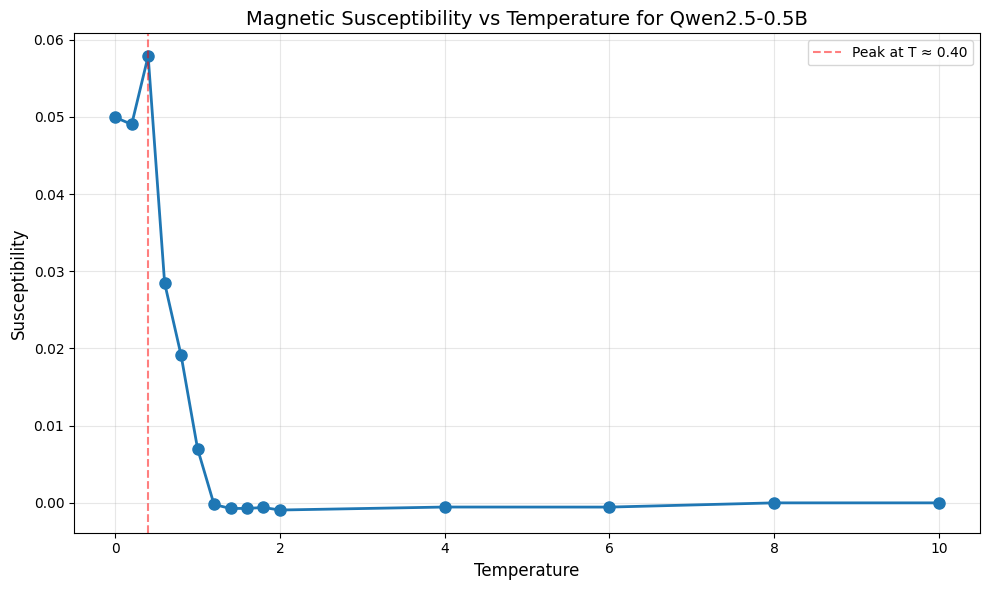